# Surfs Up Climate

In [27]:
# Import dependencies
import numpy as np
import pandas as pd
import datetime as dt

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
# Importing CSV files
measurements = pd.read_csv("Resources/hawaii_measurements.csv")
stations = pd.read_csv("Resources/hawaii_stations.csv")

In [29]:
# Display head of Measurements files
measurements.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [30]:
# Display head of Measurements files
stations.head()

,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [32]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [33]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis
Use Python and SQLAlchemy to do basic climate analysis and data exploration of your climate database. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

## Precipitation Analysis
Design a query to retrieve the last 12 months of precipitation data and plot the results

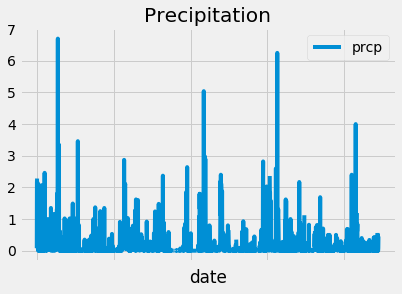

In [42]:
# Calculate the date 1 year ago from the last data point in the database
prcp12 = (session.query(Measurement.date)
        .order_by(Measurement.date.desc())
        .first())

# Taking query and turning into String
prcp12 = list(np.ravel(prcp12))[0]

# Converting String to Datetime objects
prcp12 = dt.datetime.strptime(prcp12, '%Y-%m-%d')

# Extracting into Year, Month, and Day integers 
year = int(dt.datetime.strftime(prcp12, '%Y'))
month = int(dt.datetime.strftime(prcp12, '%m'))
day = int(dt.datetime.strftime(prcp12, '%d'))

# Calculating the date one year ago from the last date point
lastyear = dt.date(year, month, day) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
date_prcp = (session.query(Measurement.date, Measurement.prcp)
            .filter(Measurement.date > lastyear)
            .order_by(Measurement.date)
            .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(date_prcp)
prcp_df = prcp_df.set_index('date')

# Sort the dataframe by date
prcp_date = prcp_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_date.plot(title="Precipitation")

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_date.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [44]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print(f"There are {stations} available in this dataset.")

There are 9 available in this dataset.


In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activeStations = (session.query(Measurement.station, func.count(Measurement.station))
                .group_by(Measurement.station)
                .order_by(func.count(Measurement.station)
                .desc())
                .all())
activeStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
# Active stations
allStations = activeStations[0][0]

# Lowest temperature recorded
lowestTemp = (session.query(Measurement.tobs)
             .filter(Measurement.station == allStations)
             .order_by(Measurement.tobs.asc())
             .first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded was: {lowestTemp}.")

The lowest temperature recorded was: 54.0.


In [56]:
# Highest temperature recorded
highestTemp = (session.query(Measurement.tobs)
              .filter(Measurement.station == allStations)
              .order_by(Measurement.tobs.desc())
              .first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded was: {highestTemp}.")

The highest temperature recorded was: 85.0.


In [61]:
# Average temperature at the most active station
averageTemp = (session.query(func.avg(Measurement.tobs))
              .filter(Measurement.station == allStations))
averageTemp = '{0:.3}'.format(averageTemp[0][0])
print(f"The average temperature is: {averageTemp}.")

The average temperature is: 71.7.


In [69]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
lastyearTemp = (session.query(Measurement.date, Measurement.tobs)
               .filter(Measurement.date > lastyear)
               .filter(Measurement.station == allStations)
               .order_by(Measurement.date)
               .all())

lastyeardf = pd.DataFrame(lastyearTemp).set_index('date')
lastyeardf = lastyeardf.sort_index(ascending=True)

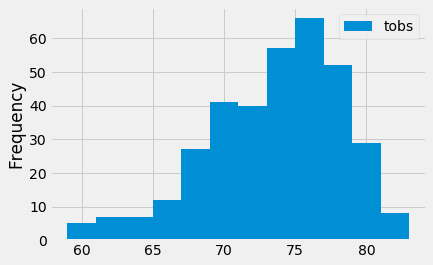

In [71]:
# Plotting with Pandas
lastyeardf.plot(kind='hist', bins=12)

In [74]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [75]:
# Setting dates
tripDates = '2012-02-28 to \n 2012-03-05'
tripStart = '2012-02-28'
tripEnd = '2012-03-05'

In [76]:
# Calculating tmin, tavg, and tmax using the calc_temps
tripCalc = calc_temps(tripStart, tripEnd)
tripCalc

[(62.0, 69.57142857142857, 74.0)]

In [79]:
# Setting tmin, tavg, tmax
tripTemp_min = tripCalc[0][0]
tripTemp_avg = tripCalc[0][1]
tripTemp_max = tripCalc[0][2]

# Errors
minError = tripTemp_avg - tripTemp_min
maxError = tripTemp_max - tripTemp_avg
errorBar = np.array([[minError], [maxError]])

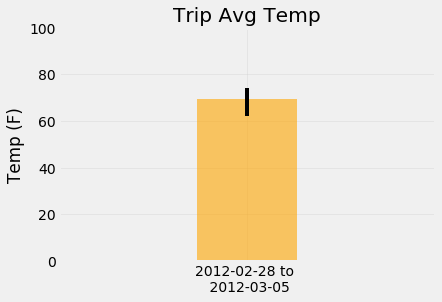

In [90]:
# Plotting results into bar chart
plt.bar(tripDates, tripTemp_avg, yerr=errorBar, color='orange', alpha=0.6)
plt.ylim(0,100)
plt.xlim(-1.5,1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

In [95]:
# Calculate the total amount of rainfall per weather station for your trip dates
# using the previous year's matching dates.
# Sort this in descending order by:
# precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station,
            Station.name,
            func.sum(Measurement.prcp),
            Station.latitude,
            Station.longitude,
            Station.elevation])
weatherStation = (session.query(*sel)
                     .filter(Station.station == Measurement.station)
                     .filter(Measurement.date >= tripStart)
                     .filter(Measurement.date <= tripEnd)
                     .group_by(Station.station)
                     .order_by(func.sum(Measurement.prcp).desc())
                     .all())

weatherStation

[('USC00519281',
  'WAIHEE 837.5, HI US',
  11.08,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  10.32,
  21.3331,
  -157.8025,
  152.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 5.79, 21.4234, -157.8015, 14.6),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  3.8400000000000003,
  21.4992,
  -158.0111,
  306.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  2.92,
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  1.1800000000000002,
  21.2716,
  -157.8168,
  3.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  0.76,
  21.3152,
  -157.9992,
  0.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.03,
  21.5213,
  -157.8374,
  7.0),
 ('USC00517948', 'PEARL CITY, HI US', 0.0, 21.3934, -157.9751, 11.9)]